In this part of the assignment, you will use data sourced from the Open Database of Addresses (ODA) provided courtesy of Statistics Canada. You can find the link to the database here: https://www.statcan.gc.ca/en/lode/databases/oda. 

This data is provided under the terms of the [Open Government License - Canada](https://open.canada.ca/en/open-government-licence-canada). 

You can find the data as a zipfile in D2L with the assignment, and you should unpack this and run it in the same directory as this notebook.


## Question 1

First, explore your data and the conversion task that you will be working with. In the cell below:

Compare the conversion of the files to parquet using different compression algorithms. What is the difference between using no compression, snappy, and gzip? Comment on processing times and approximately how much compression you observe has been achieved with this data.

Note: You may have some issues running this with the brotli compression algorithm.

Based on any sources you can find online (please include your references cite them approriately), how different would using brotli be? What would you expect in terms of processing time?


In [2]:
import pandas as pd
import random

from pathlib import Path

def convert_csv_to_parquet( src, dst):
    # print(f"Converting {src} to {dst}")
    df = pd.read_csv(src, low_memory=False)
    df.to_parquet(dst, compression='snappy')
    
file_list = list(Path('address_data').glob('address_*.csv'))
# print (file_list)
random.shuffle(file_list)

In [3]:
%%time
for ind, src in enumerate(file_list):
    print(f"{len(file_list)-ind} ", end='')
    dest = str(src.with_suffix('.parquet'))
    convert_csv_to_parquet(src, dest)
print()

48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 
CPU times: user 38.4 s, sys: 5.85 s, total: 44.3 s
Wall time: 44.9 s


In [30]:
import pandas as pd
import time
import os
from pathlib import Path


def measure_characteristics(src, compression):
    # Read input CSV file
    df = pd.read_csv(src, low_memory=False)

    # Measure compression speed and resource usage
    start_time = time.time()
    dest = src.parent / f"{src.stem}_{compression}.parquet"
    df.to_parquet(dest, compression=compression)
    compression_time = time.time() - start_time

    # Measure compression ratio
    original_size = os.path.getsize(src)
    compressed_size = os.path.getsize(dest)
    compression_ratio = compressed_size / original_size

    # Measure decompression speed
    start_time = time.time()
    pd.read_parquet(dest)
    decompression_time = time.time() - start_time

    return compression_ratio, compression_time, decompression_time

# Get the list of CSV files in the 'address_data' directory
file_list = list(Path('address_data').glob('address_*.csv'))

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['file', 'algorithm', 'compression_ratio', 'compression_time', 'decompression_time'])

# List of compression algorithms
compression_algorithms = ["snappy", "gzip", "brotli"]

# Measure characteristics for each compression algorithm and each file
for src in file_list:
    print(f"Processing file: {src}")
    for algorithm in compression_algorithms:
        ratio, comp_time, decomp_time = measure_characteristics(src, algorithm)
        print(f"{algorithm}: Compression Ratio: {ratio:.2f}, Compression Time: {comp_time:.2f}s, Decompression Time: {decomp_time:.2f}s")
        # Create a new DataFrame with the results and concatenate it with the existing DataFrame
        row_df = pd.DataFrame([{
            'file': src,
            'algorithm': algorithm,
            'compression_ratio': ratio,
            'compression_time': comp_time,
            'decompression_time': decomp_time
        }])
        results_df = pd.concat([results_df, row_df], ignore_index=True)


Processing file: address_data/address_large_6.csv
snappy: Compression Ratio: 0.29, Compression Time: 1.49s, Decompression Time: 0.90s
gzip: Compression Ratio: 0.18, Compression Time: 3.22s, Decompression Time: 0.80s
brotli: Compression Ratio: 0.16, Compression Time: 5.25s, Decompression Time: 0.65s
Processing file: address_data/address_large_7.csv
snappy: Compression Ratio: 0.30, Compression Time: 0.80s, Decompression Time: 0.62s
gzip: Compression Ratio: 0.19, Compression Time: 3.01s, Decompression Time: 0.65s
brotli: Compression Ratio: 0.17, Compression Time: 4.69s, Decompression Time: 0.71s
Processing file: address_data/address_large_5.csv
snappy: Compression Ratio: 0.32, Compression Time: 0.91s, Decompression Time: 0.69s
gzip: Compression Ratio: 0.21, Compression Time: 3.36s, Decompression Time: 0.81s
brotli: Compression Ratio: 0.19, Compression Time: 5.78s, Decompression Time: 0.67s
Processing file: address_data/address_small_8.csv
snappy: Compression Ratio: 0.41, Compression Time:

In [31]:
# Find the average compression ratio, compression time and decompression time for each compression algorithm
average_values = results_df.groupby('algorithm')[['compression_ratio', 'compression_time', 'decompression_time']].mean()
# Sort the results by compression ratio
average_values.sort_values(by='compression_ratio', inplace=True)
average_values

,compression_ratio,compression_time,decompression_time
algorithm,,,
brotli,0.219087,1.551039,0.180467
gzip,0.241605,0.957934,0.184424
snappy,0.358794,0.253075,0.170744


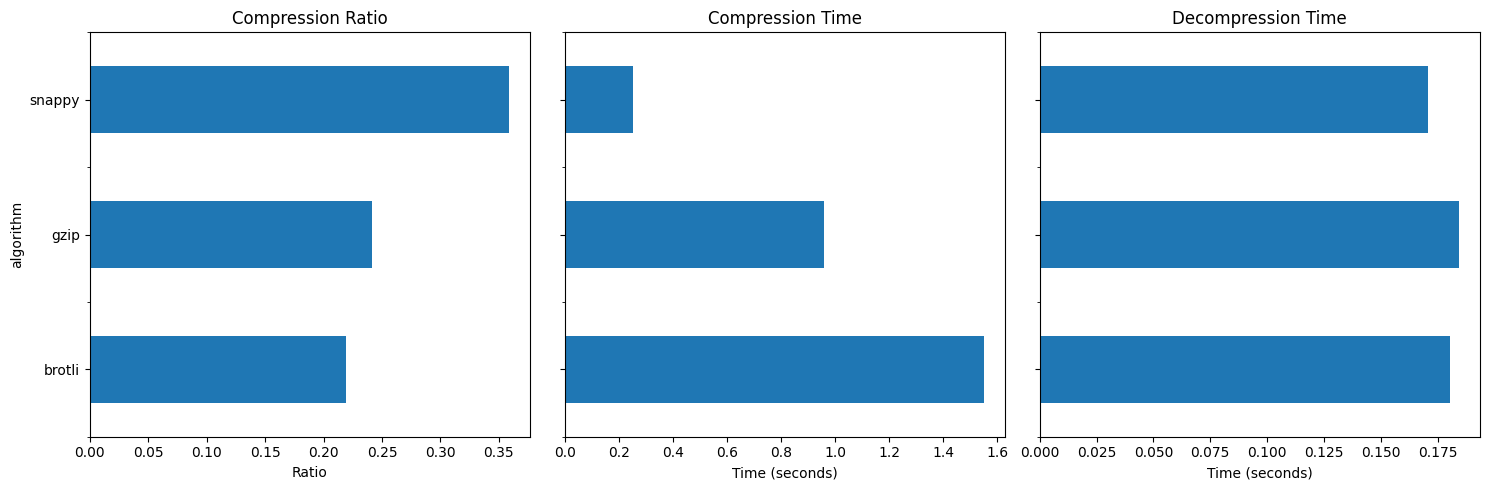

In [32]:
# Plot the results for compression ratio, compression time and decompression time for each compression algorithm
# Create bar plots for compression ratio, compression time, and decompression time
import matplotlib.pyplot as plt

# Create horizontal bar plots for compression ratio, compression time, and decompression time
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

average_values['compression_ratio'].plot(kind='barh', ax=axes[0], title='Compression Ratio', xlabel='Ratio')
average_values['compression_time'].plot(kind='barh', ax=axes[1], title='Compression Time', xlabel='Time (seconds)')
average_values['decompression_time'].plot(kind='barh', ax=axes[2], title='Decompression Time', xlabel='Time (seconds)')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Compression ratio is the ratio of the size of the compressed file to the size of the original file.
- The best compression is achieved by using the `brotli` algorithm.
    - But the pay-off is that the compression time is the _longest_.
- It's worth noting that the compression ratio of the `gzip` algorithm is not that far behind.
    - But the compression time is much _shorter_ than the `brotli` algorithm.
- The _inverse relationship_ between compression ratio and compression time could be spotted as expected.
- Decompression time (time that it takes to read compressed file back to its original state) is also an inverse of compression ratio but the difference doesn't seem that big.

**Overall, the choice of compression algorithm depends on the task at hand. If the goal is save the space on disk, then `brotli` or `gzip` is the best choice. If the goal is to save time (compressing and decompressing), then `snappy` is the best choice.**

## Question 2

Parallelize the code above using either processes or threads.

Use comments reading `# MODIFIED` to indicate any code cells you have changed and `# NEW` to indicate any code cells you have added.

With respect to the improvement in runtimes, do you think this is reasonably characteristic? What happens if you use a pool of threads or processes? 


In [1]:
%%time
from pathlib import Path
# here I am using pathos instead of multiprocessing
# as the latter doesn't work on my machine
from pathos.multiprocessing import ProcessingPool as Pool
from pathos.threading import ThreadPool as Thread
import pandas as pd

file_list = list(Path('address_data').glob('address_*.csv'))

def convert_csv_to_parquet(src, dst):
    df = pd.read_csv(src, low_memory=False)
    df.to_parquet(dst, compression='snappy')

def process_file(src):
    # print(f"Processing {src}")
    dst = str(src.with_suffix('.parquet'))
    convert_csv_to_parquet(src, dst)

# NEW: Parallelize the conversion of CSV files to Parquet files
with Thread(5) as pool: # Pool(5) as pool: for using processes
    pool.map(process_file, file_list)
    pool.close()
    pool.join()

CPU times: user 46.5 s, sys: 8.88 s, total: 55.3 s
Wall time: 28.7 s


## Question 3

Share one way in which you could improve the running of this test. You may consider (but are not limited to) your runtime environment, the test data provided, or the manner in which this test was run.

Sequential processing:
CPU times: user 38.4 s, sys: 5.85 s, total: 44.3 s
Wall time: 44.9 s

Pools processing:
CPU times: user 917 ms, sys: 353 ms, total: 1.27 s
Wall time: 14.6 s

Threads processing:
CPU times: user 46.5 s, sys: 8.88 s, total: 55.3 s
Wall time: 28.7 s

Reading multiple CSV files and compressing them is typically a combination of both I/O-bound and CPU-bound tasks.

The I/O-bound component:
Reading the CSV files from disk involves disk I/O operations.
Writing the compressed files back to disk also involves disk I/O operations.

The CPU-bound component:
The compression algorithm requires CPU processing to compress the data efficiently.

Pool of Processes: suitable for CPU-bound tasks with minimal inter-process communication or shared data
Pool of Threads: suitable for I/O-bound tasks that require frequent communication and shared data.

For this type of task, using a combination of thread-based and process-based parallelism can be effective. We can use a thread pool to manage the I/O-bound parts, like reading and writing files, while using a process pool to handle the CPU-bound compression.

**To do this, we can separate the I/O-bound and CPU-bound tasks into separate functions and then use a thread pool to run the I/O-bound tasks and a process pool to run the CPU-bound tasks.**
